# Analyze Boston

## Track 1: Reducing Boston’s Carbon Footprint

Ignacio Carracedo / nachocarracedo@gmail.com

**1. INTRODUCTION** 

**2. DATA PREPARATION **
   
**3. VISUALIZATIONS **

    3.1. Map    
    3.2. Buildings  
    3.3. Buildings types    
    3.4. Decade built



## 1. INTRODUCTION

In order to achive a carbon neutral Boston by 2015 the city needs a good tracking system to explore BERDO data. Tracking how buildings are doing thought the years yield valuable information. This information can be then use to focus on certain buildings, zones, or buildings properties that need improvement. The information can also be used to understand that factors are helping reduce green house gas emissions.

The goal of this notebook is to clean the data and give some vizualization examples that show the change from 2014 to 2015. The focus has been tracking how green house emissions has changed, comparing these results with the energy comsuption change and the share of each energy source (electricity, gas, steam). We will explore indivial buildings as well as types of buildingas and decades.

It's important to understand that as of today, only 2 years worth of data is available which limits the amount of information we can extract.

Time was of the essence as I only had one week till the deadline for submission so the scope of the project was to show some examples. The long term plan is to use this notebook to find the most informative visualizations and use them to create a dashboard to track BERNO every year.

----------------------------------------------

First, let's import all modules used on this notebook:

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline
plt.style.use('fivethirtyeight')

import requests
import warnings
warnings.filterwarnings('ignore')

Here are the versions of Python, modules, server where this notebook was created:

In [2]:
%load_ext watermark

%watermark -d -v -m -p numpy,pandas,matplotlib

2017-04-25 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


----------------------------------------------

## 2. DATA PREPARATION

Next, we load the BERDO datasets available (2014, 2015) and we joined them using the features `Address` and `Property Name`.

In [3]:
# read data
berdo2015 = pd.read_csv(".//data/berdo2015.csv",
                        encoding = "ISO-8859-1")
berdo2014 = pd.read_csv(".//data/berdo2014.csv",
                        encoding = "ISO-8859-1")

# sizes
print("Size of BERDO 2014 data set: %s" %(berdo2014.shape[0]))
print("Size of BERDO 2015 data set: %s" %(berdo2015.shape[0]))
print("\n........ Merging ........\n")

# merge
berdo = pd.merge(berdo2015,
                 berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014')) # sufixes for both data sets

# final size
print("Size of joined BERDO data set: %s" %(berdo.shape[0]))

Size of BERDO 2014 data set: 1380
Size of BERDO 2015 data set: 1502

........ Merging ........

Size of joined BERDO data set: 1085


**[NOTE/TO DO]** Not all buildings were in both data sets, at least the property name/address didn't match for all listings. A simple typo would have left some listing out of the final data set. We would need to inspect the data set to see if this is the case.

Of all the data set we are interested in the following features:

* **Property Name**: Property name, as reported by owner
* **Address**: Reported address
* **Site EUI (kBTU/sf)**: Site energy use intensity, or EUI (in kBTU/sq. ft.): This sums up all of the energy used in the building (electricity, gas, steam, etc.) each year, and divides by square footage. There are many drivers of energy use intensity, such as energy-intensive work, and, since EUI is not adjusted for these factors, it is not a definitive indicator of building efficiency. (This metric uses site energy, not source energy.)
* **Property Uses**: List of space uses reported for this property
* **Year Built**: Year built, as reported by the owner
* **GHG Intensity (kgCO2/sf)**: GHG intensity (kgCO2/sf) divides total GHG emissions by square footage.
* **Total Site Energy (kBTU)**: Total energy used in 2014 (kBTU). This is a gross sum of all annual energy use in the building, not adjusted for size or uses.
* **% Electricity**: Percent of total energy that is electricity
* **% Gas**: Percent of total energy that is gas
* **% Steam**: Percent of total energy that is steam

Next, we proceed to clean the data set, here are the steps taken:

* `fix_numerical`: columns that are considered numerical are transformed into an number
* `fix_percenteage`: columns with a percent are transforemd into numbers
* bad values are transfored into `-1`. This values will later be removed.

In [4]:
cols_num = ['Gross Area (sq ft)',
            'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)',
            'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ',
            'Water Intensity (gal/sf)'
           ]

cols_percent = ["% Gas",
                "% Steam",
                "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%",
                                inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columns
fix_numerical(cols_num)
fix_percenteage(cols_percent)

We calculate the total % of energy adding the 3 % features. We want to check how many of them add up to 100%. We could filter out the ones that are not close to 100 but there might me other sources of energy not reported so we decide to leave those observations in.

For the feature `Year Built` we set to 0 all years before 1600. These are typos (year was reported by the user). After that create a feture `decade`, this will allow ups to explore buidings by the decade they were built in.

In [5]:
# calculates total enery to see if it adds up to 100%
berdo["%_total_2015"] = berdo[["% Gas_2015",
                               "% Steam_2015",
                               "% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014",
                               "% Steam_2014",
                               "% Electricity_2014"]].sum(axis=1)

# fix 'year built' 
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: 
                                                        0 
                                                        if x<1600
                                                        else x)

# create feature `decade`
berdo["decade"] = berdo["Year Built_2015"].map(lambda x:
                                               int(str(x)[:-1]+"0") 
                                               if x>1 
                                               else x)

I noticed that sometimes, the differecen between the Energy use of a year was much higher than from the other year, which was almost non existent. This is due to the builing being renovated. To avoid counting this buildings when tracking energy/ghg I create a new `feature` that flag buidings as being renovated or unders contruction for a particular year. When ploting we'll remove these buldings as they could be misleading. 

Shown below is a list of buidings being flaged:

In [6]:
def possible_construction (row):
    """ if energy difference is higher by more than 100 times
        the row is mark as 1. Otherwise 0 """
    
    y2015 = row["Site EUI (kBTU/sf)_2015"]
    y2014 = row["Site EUI (kBTU/sf)_2014"]
    if y2015 > y2014:
        if y2015/y2014 > 100:
            return 1
        else:
            return 0
    else:
        if y2014/y2015 > 100:
            return 1
        else:
            return 0

berdo["under_construction"] = berdo.apply(possible_construction, axis=1)

# show possible "UNDER CONSTRUCTION"
berdo[berdo["under_construction"] == 1][["Property Name","Address",
                                         "Site EUI (kBTU/sf)_2015",
                                         "Site EUI (kBTU/sf)_2014",
                                         "GHG Intensity (kgCO2/sf)_2015",
                                         "GHG Intensity (kgCO2/sf)_2014"]]

,Property Name,Address,Site EUI (kBTU/sf)_2015,Site EUI (kBTU/sf)_2014,GHG Intensity (kgCO2/sf)_2015,GHG Intensity (kgCO2/sf)_2014
106,230 Congress Street,230 Congress Street,25693.9,219.1,1712.0,20.5
119,26 Irwin Av,26 Irwin Av,200.3,1.5,11.3,0.1
197,543-547 Washington Street,543-547 Washington Street,166.6,73235.1,13.3,4865.0
379,BROOKLINE ICE,225 SOUTHHAMPTON ST,5634.3,34.9,545.1,3.4
691,Landmark at Longwood,63 Parket Hill Road,75.7,0.2,7.3,0.0
1081,YMCA of Greater Boston - Constitution Inn,150 Second Avenue,61.3,25348.8,3.8,1347.5
1082,YMCA of Greater Boston - Huntington,316 Huntington Avenue,202.8,69141.5,13.4,3674.6


Now I remove missing values or bad data:

* All rows with -1 on a columns.
* All rows where `under_construction` is 0.

106 observations out of 1085 were removed due to either missing values or bad data. This data could be revisited in the future.

In [7]:
print("Size before removing bad/missing values: %s" %berdo.shape[0])

# remove under construction
berdo = berdo[berdo.under_construction != 1]

# feature selection
berdo = berdo[["Property Name","Address","ZIP_2015",
               "Year Built_2015","decade",
               "Property Type_2015","Property Type_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014"
              ]]

# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)

print("Size after removing bad/missing values: %s" %berdo.shape[0])

Size before removing bad/missing values: 1085
Size after removing bad/missing values: 979


Now, we are creating a final `Data.Frame` called `berdo_diff` that will have the difference between the year 2015 and 2014.

2015 data will be subtracted from 2014 data, thus, positive values mean a decrease (2014 data was higher than 2015 data) and negative values mean there has been and increase.

In [8]:
# new data frame
berdo_diff = pd.DataFrame()

# property info
berdo_diff[["property_name", "address",
            "zip","year_built","decade"]] = berdo[["Property Name",
                                                   "Address","ZIP_2015",
                                                   "Year Built_2015","decade"]]
# property type
berdo_diff[["property_type_2015",
            "property_type_2014"]] = berdo[["Property Type_2015",
                                            "Property Type_2014"]]

# energy diff
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2014"] \
                                  - berdo["Site EUI (kBTU/sf)_2015"]

# ghg diff
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2014"] \
                                          - berdo["GHG Intensity (kgCO2/sf)_2015"]

# energy %
berdo_diff[["%_electricity_2015",
            "%_gas_2015",
            "%_steam_2015"]] = berdo[["% Electricity_2015",
                                      "% Gas_2015",
                                      "% Steam_2015"]]
berdo_diff[["%_electricity_2014",
            "%_gas_2014",
            "%_steam_2014"]] = berdo[["% Electricity_2014",
                                      "% Gas_2014",
                                      "% Steam_2014"]]

To start the visualization secction we want to plot the builidings on a map, thus, we need the latitude and longitude. There are many ways to do this. I use google maps API (`get_long_lat`) to look for the address and extract both longitued and latitude. the process is run a second time (`redo_long_lat`) in case some API called timed out the first iteration.

In [9]:
import requests

def get_long_lat(address):
    """recieves and Boston address and looks for longitude 
       and latitude using google maps API. Returns string 
       with both values. Values are 0 if error """
    
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
            + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)


def redo_long_lat(row):
    """if the field lat_long is '0 0'
       the funtion tries to retrieve longitude 
       and latitude from google maps API"""
    
    if row["lat_long"] == "0 0":
        address = row["address"]  
        fix_add = address.replace(" ","+")
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
                + fix_add + ',+Boston,+Massachusetts,+USA'
        try:        
            response = requests.get(url)
            resp_json_payload = response.json()
            #print(resp_json_payload)
            info = (resp_json_payload['results'][0]['geometry']['location'])
            return str(info['lat'])+" "+str(info['lng'])
        except:
            return "0 0" 
    else:
        return row["lat_long"]

berdo_diff["lat_long"] =  berdo_diff.apply(redo_long_lat, axis=1)

# creates features longitude and latitude
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

# save
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

----------------------------------------------

## 3. VISUALIZATIONS

This second part of the notebook shows some visualizations to help tracking energy and green house emissions.


### 3.1 MAP

First, we want to see all properties in 2 maps. The 1st map colored the properties by energy intensity difference between 2014 and 2015. The 2nd map does the same using green house gas instensity. The colors represent the following:

* Increase: value in 2015 was higher that in 2014 (red)
* Neutral: value in 2015 was the same as in 2014 (orange)
* Decrease: value in 2015 was lower that in 2014 (green)

In [ ]:
# loads data to start executing notebook from this cell
#berdo_diff = pd.read_csv("./data/berdo_diff.csv")

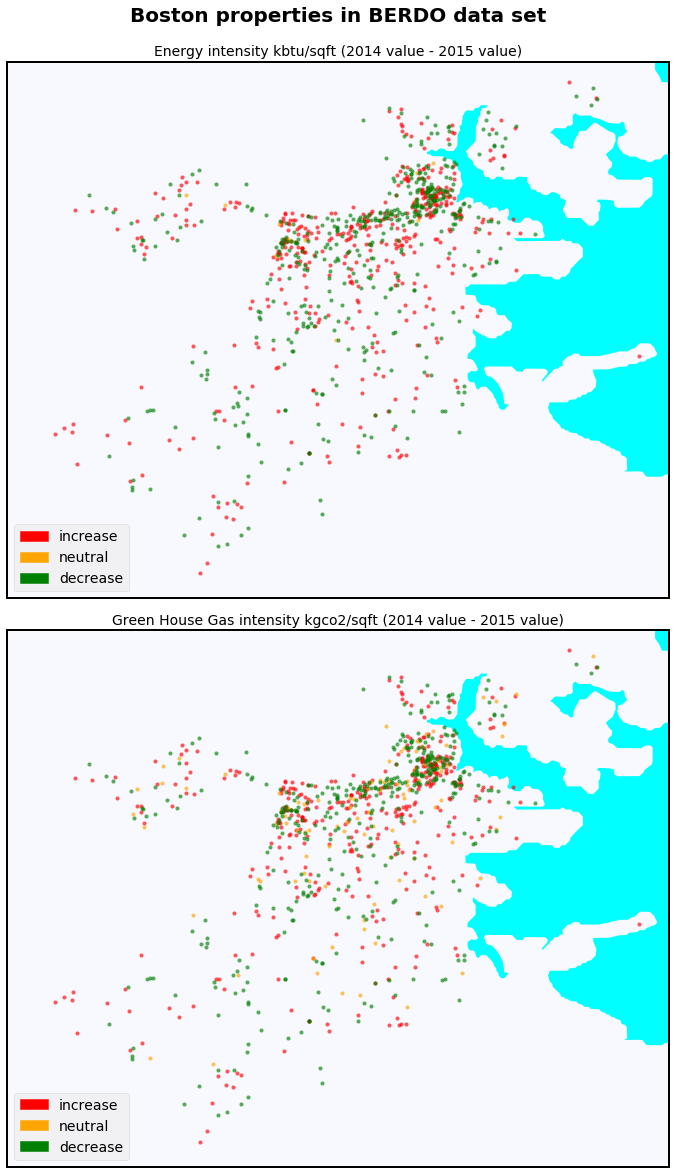

In [13]:
# boston limits
west, south, east, north = -71.1958, 42.2254, -70.9804, 42.40

# figure
fig = plt.figure(figsize=(12,16),
                 facecolor='white')

plt.suptitle("Boston properties in BERDO data set", y=1.02, fontsize=20,fontweight = 'bold')


########################### ENERGY MAP
fig.add_subplot(211)
plt.title("Energy intensity kbtu/sqft (2014 value - 2015 value)", size=14)

# coloring split
increase = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north, 
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='ghostwhite',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="aqua")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 

m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='orange',
       alpha=0.65,
       markeredgecolor='orange',
       markeredgewidth=0.05) 

m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='orange',
                              label='neutral')
green_patch = mpatches.Patch(color='green',
                             label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch]
              ,loc='lower left')

for text in l.get_texts():
    text.set_color("black")
    
    
########################### GHG MAP
fig.add_subplot(212)
plt.title("Green House Gas intensity kgco2/sqft (2014 value - 2015 value)", size=14)

# coloring split
increase = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='ghostwhite',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="white")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 

m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='orange',
       alpha=0.65,
       markeredgecolor='orange',
       markeredgewidth=0.06) 

m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='orange',
                              label='neutral')
blue_patch = mpatches.Patch(color='blue',
                            label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch],
               loc='lower left')

for text in l.get_texts():
    text.set_color("black")

# show figure    
plt.tight_layout()    
plt.show()

### 3.2 BUILDINGS

Now we can drill down on these differences we see on the map. There are many ways we can look at this data. Here I show a few. 

Before continuing we need to exclude one value where the difference is in energy and ghg is too big:

Now we are ready to plot:

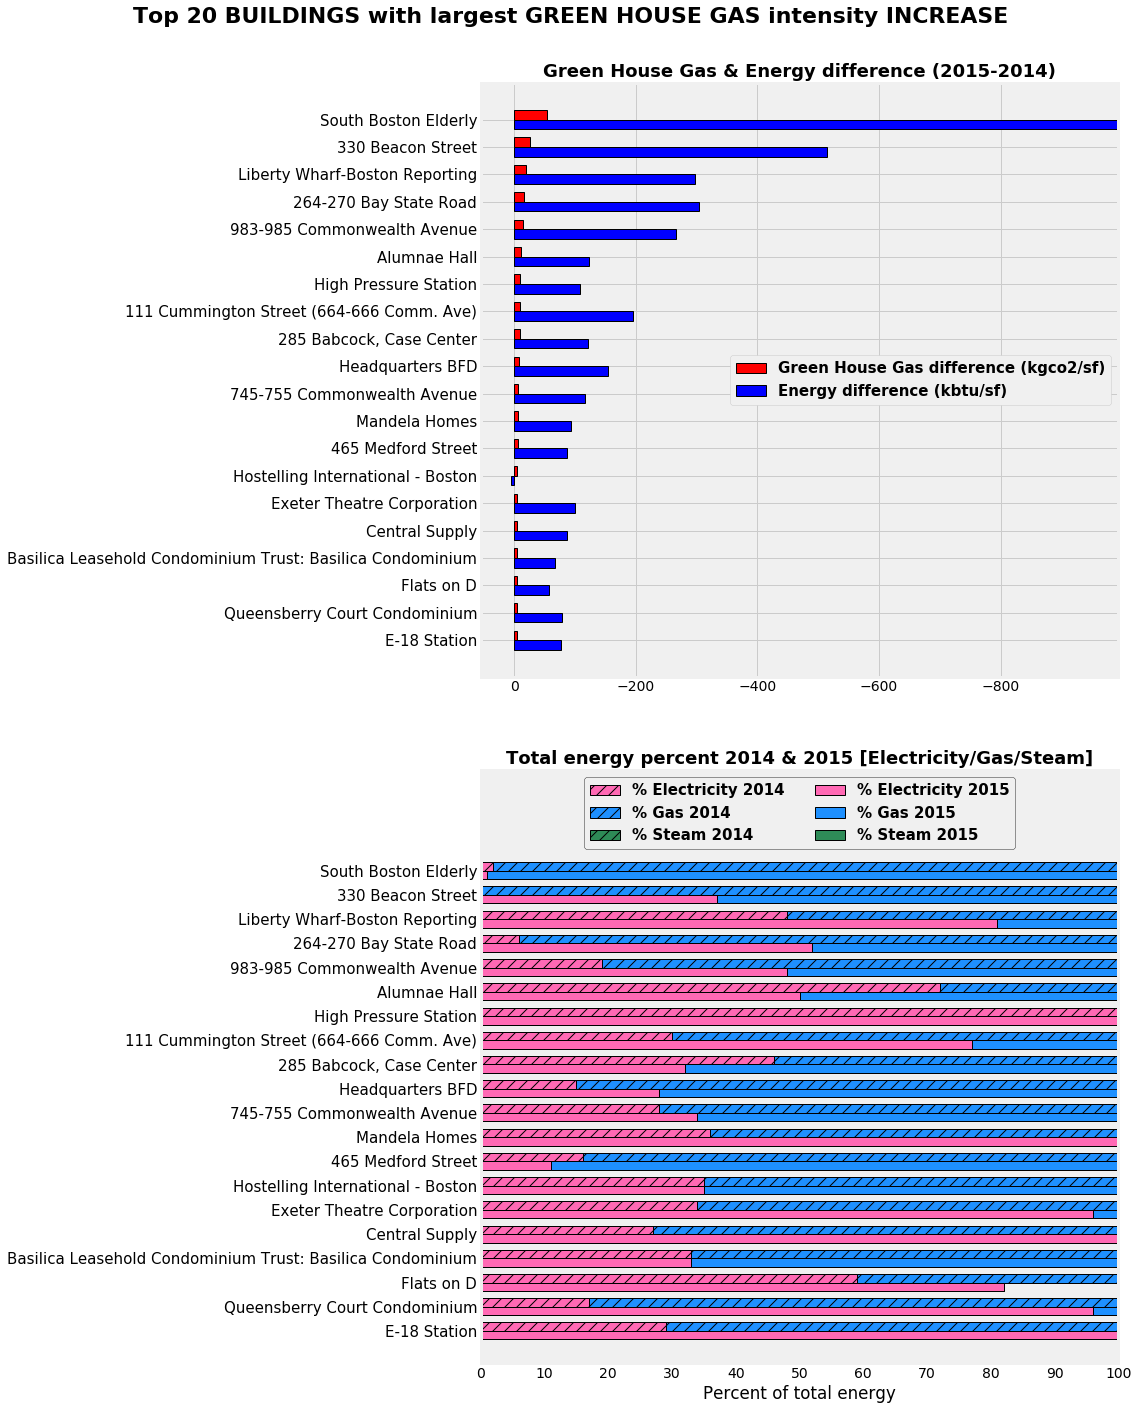

In [14]:
######################## TOP20 WORST - DIFF PLOT
# data to plot
c = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff']).iloc[:20]

# plot 
plt.figure(figsize=(16, 19),
           facecolor='white')

plt.suptitle("Top 20 BUILDINGS with largest GREEN HOUSE GAS intensity INCREASE",
             y=1.03,
             fontweight='bold',
             fontsize=22)

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Green House Gas & Energy difference (2015-2014)",
          size=18,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=aa,
             width=c["energy_kbtu/sf_diff"].values,
             color="b",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width,)
p2 = ax.barh(bottom=bb,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="r",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c['property_name']], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas difference (kgco2/sf)',
            'Energy difference (kbtu/sf)'),
            loc='center right',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TOP20 WORST- PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff']).iloc[:20]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))
plt.title("Total energy percent 2014 & 2015 [Electricity/Gas/Steam]",
          size=18,
          fontweight = 'bold')

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
             linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"])

plt.yticks(ind-4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.property_name], size=15)
ax1.grid(False)
ax1.invert_yaxis()

plt.xlabel('Percent of total energy')#,fontweight = 'bold')
plt.xticks(np.arange(0,101,10))

# legend
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

# show figure    
plt.tight_layout(h_pad=4)   
plt.show()

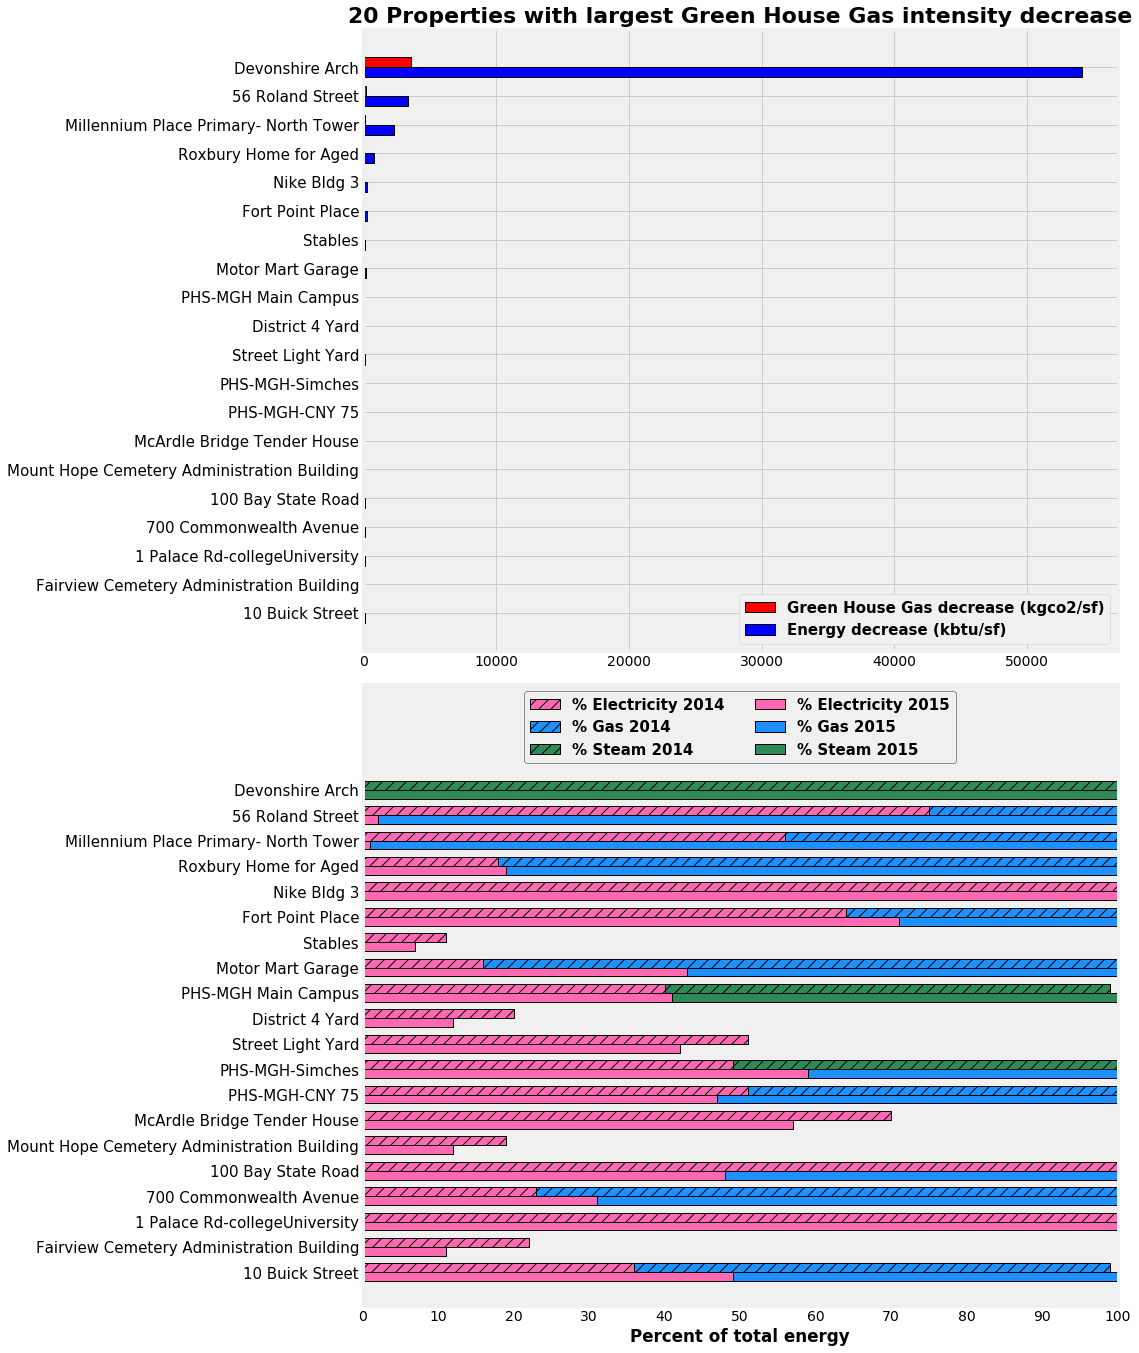

In [15]:
######################## TOP20 BEST - DIFF PLOT

# data to plot
c = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff'],ascending=False).iloc[:20]

# plot 
plt.figure(figsize=(16, 19),
           facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))
plt.title("20 Properties with largest Green House Gas intensity decrease",
          size=22,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=aa,
             width=c["energy_kbtu/sf_diff"].values,
             color="b",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width,)
p2 = ax.barh(bottom=bb,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="r",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

ax.invert_yaxis()
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c['property_name']], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas decrease (kgco2/sf)',
            'Energy decrease (kbtu/sf)'),
            loc='lower right',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TOP20 BEST - PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff'],ascending=False).iloc[:20]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
             linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"])

plt.yticks(ind-4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.property_name], size=15)
ax1.grid(False)
ax1.invert_yaxis()

plt.xlabel('Percent of total energy',fontweight = 'bold')
plt.xticks(np.arange(0,101,10))

# legend
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

# show figure    
plt.tight_layout()    
plt.show()

explain above

### 3.2 BUILDINGS TYPES

introduce below

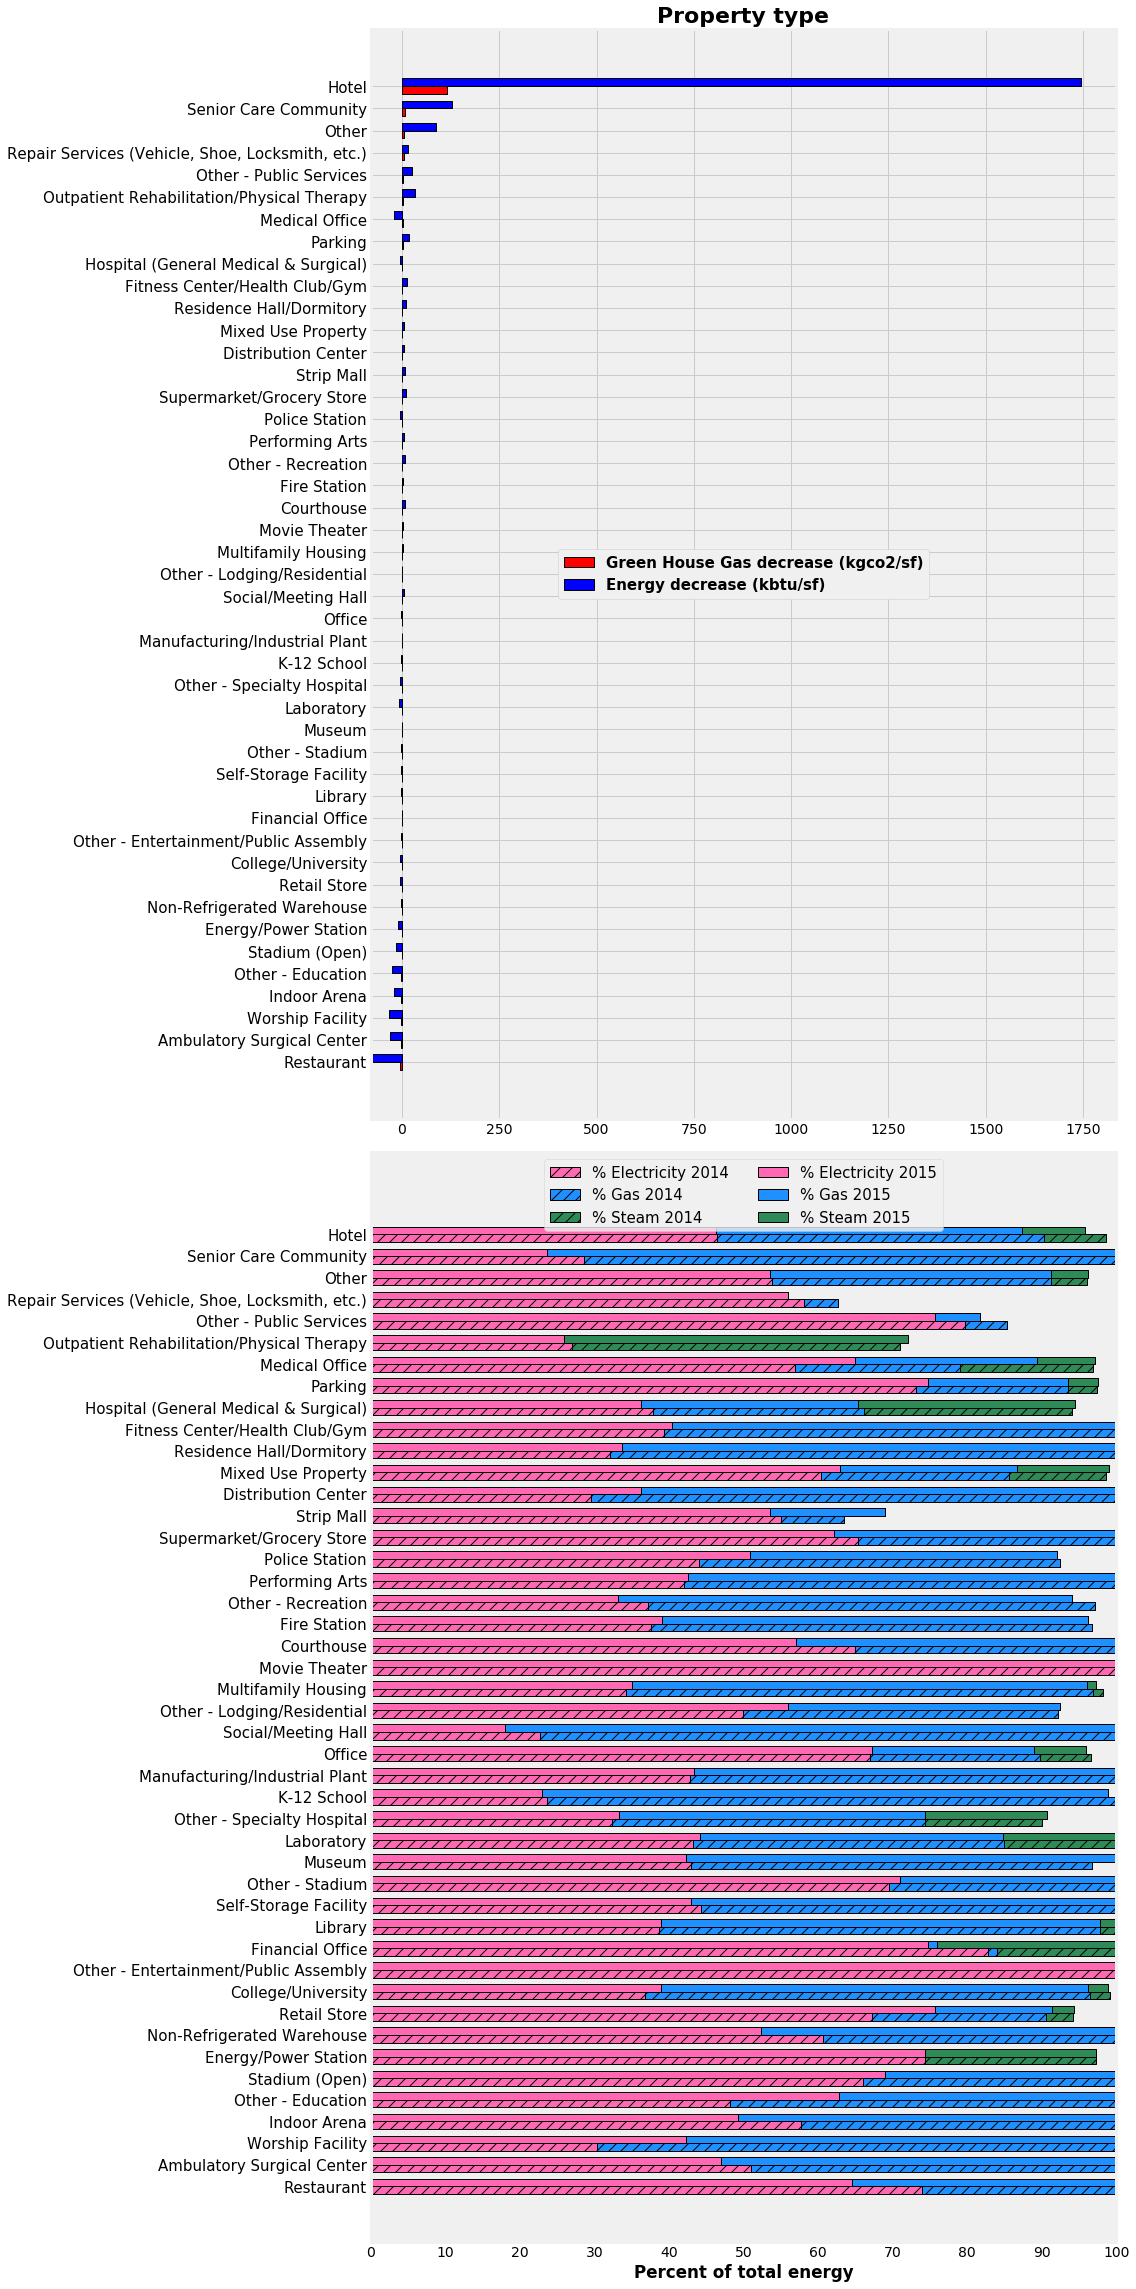

In [16]:
######################## TYPE PROPERTY -  DIFF PLOT
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].mean().sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].mean().sort_values()
stde = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].std().sort_values().fillna(0).rename("energy_std")
stdg = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].std().sort_values().fillna(0).rename("ghg_std")
c = pd.concat([a, b,stde,stdg], axis=1).sort_values(by='ghg_intensity_kgco2/sf_diff')

# plot 
plt.figure(figsize=(16, 32),
           facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Property type",
          size=22,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=aa,
             width=c["energy_kbtu/sf_diff"].values,
             color="b",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width,)
p2 = ax.barh(bottom=bb,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="r",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas decrease (kgco2/sf)',
            'Energy decrease (kbtu/sf)'),
            loc='center',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TYPE PROPERTY - PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.groupby(["property_type_2015"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                        "%_gas_2014","%_steam_2014","%_electricity_2015",
                                        "%_gas_2015","%_steam_2015"]].mean()
bad_energy_share= pd.concat([c,bad_energy_share], axis=1).sort('ghg_intensity_kgco2/sf_diff')


#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
            linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.index], size=15)
ax1.grid(False)

plt.xlabel('Percent of total energy',fontweight = 'bold')
plt.xticks(np.arange(0,101,10))
#legend
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15},
            loc='upper center',
            ncol=2)

plt.tight_layout()
plt.show()

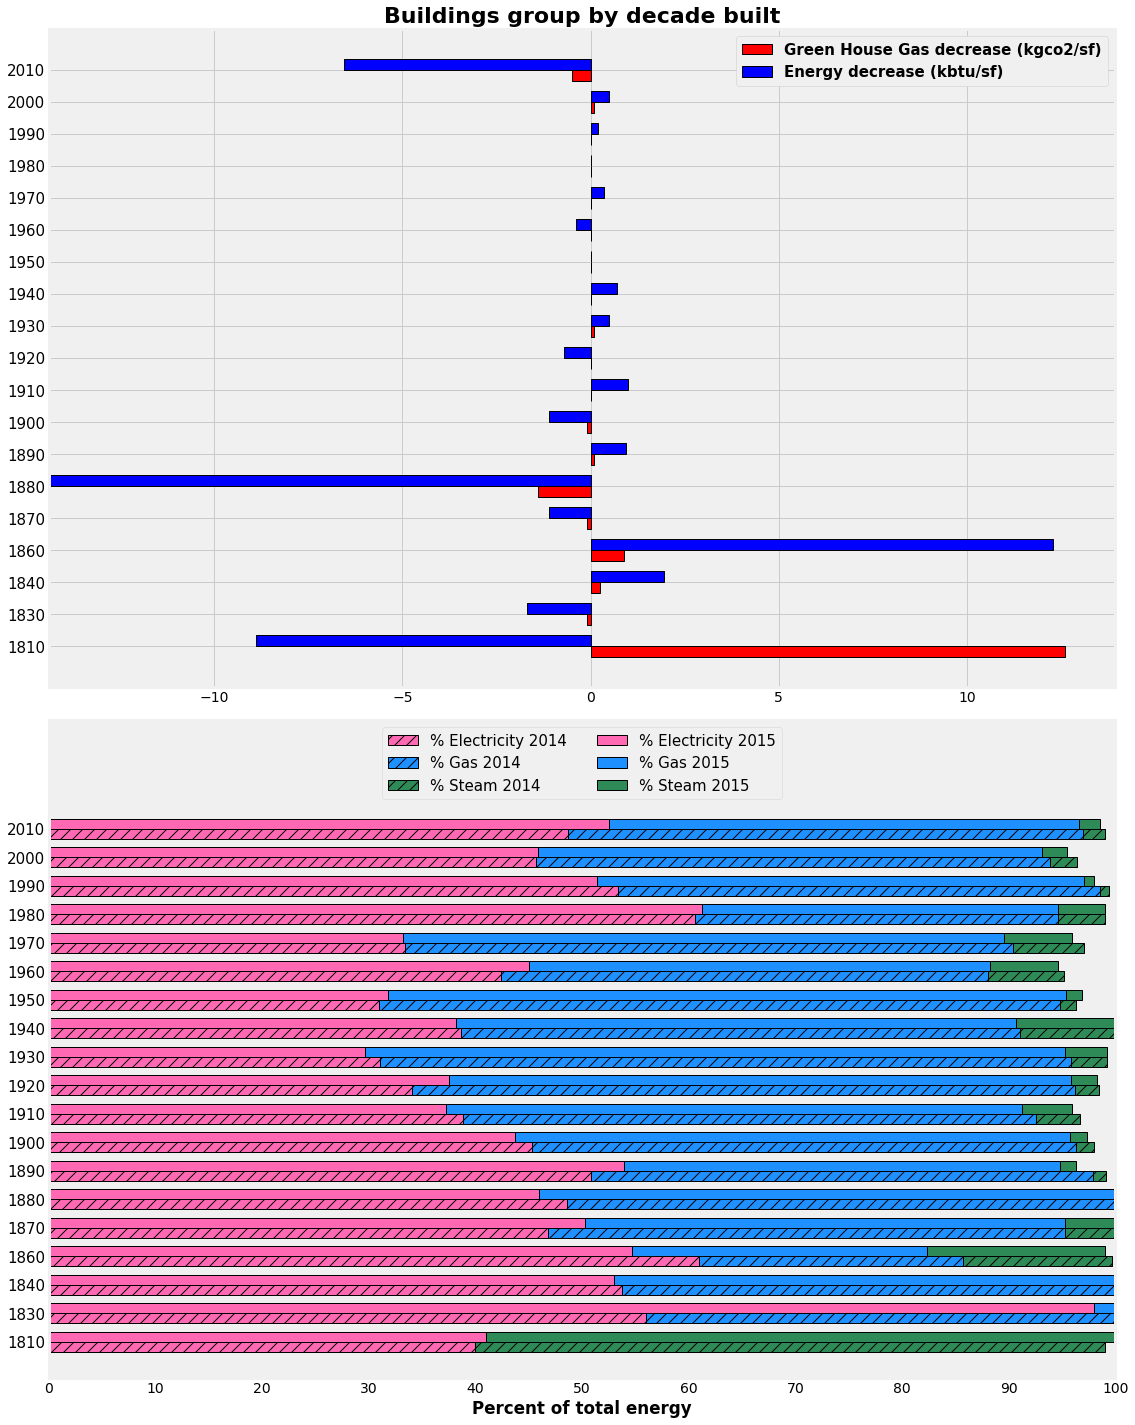

In [17]:
# data to plot
a = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['energy_kbtu/sf_diff'].median().sort_values()
    
b = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['ghg_intensity_kgco2/sf_diff'].median().sort_values()
    
stde = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['energy_kbtu/sf_diff'].std().sort_values().fillna(0).rename("energy_std")
    
stdg = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['ghg_intensity_kgco2/sf_diff'].std().sort_values().fillna(0).rename("ghg_std")
    
c = pd.concat([a, b,stde,stdg], axis=1).sort_index()

# plot
plt.figure(figsize=(16, 20),
           facecolor='white')
#plt.suptitle(title_string, y=1.05, fontsize=18)


ax=plt.subplot2grid((2,1), (0,0))
plt.title("Buildings group by decade built",
          size=22,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)
ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas decrease (kgco2/sf)',
            'Energy decrease (kbtu/sf)'),
            loc=0,
            prop={'size':15,'weight':'bold'},
            framealpha=1)

######################## TYPE PROPERTY - PERCENT ENERGY PLOT
# data to plot
energy_share = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                        "%_gas_2014","%_steam_2014","%_electricity_2015",
                                        "%_gas_2015","%_steam_2015"]].mean()
energy_share= pd.concat([c,energy_share], axis=1).sort_index()


#stacked bars
aa=  [x+width for x in range(len(energy_share.index))]
bb = [x for x in range(len(energy_share.index))]

ind = np.arange(len(energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))

w1 = ax1.barh(aa,
              energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= energy_share["%_electricity_2014"]+energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
            linewidth = 1)
v2 = ax1.barh(bb,
              energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= energy_share["%_electricity_2015"]+energy_share["%_gas_2015"],)

plt.yticks(ind+4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in energy_share.index], size=15)
ax1.grid(False)

plt.xlabel('Percent of total energy',fontweight = 'bold')
plt.xticks(np.arange(0,101,10))
#legend
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15},
            loc='upper center',
            ncol=2)

plt.tight_layout()
plt.show()